# Tidal Heating and Torque versus Semi-major Axis
An example of using TidalPy functions


In [1]:
# Setup Jupyter environment and load in useful packages 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G

In [2]:
# Import TidalPy 
from TidalPy.constants import mass_solar, mass_earth, radius_earth
from TidalPy.utilities.conversions import days2rads, m2Au, Au2m, orbital_motion2semi_a, semi_a2orbital_motion
from TidalPy.rheology import find_complex_compliance, complex_compliances, rheology_styles
from TidalPy.tides import calculate_tides
from TidalPy.dynamics import mode_types

In [3]:
# Star and Planet Properties
star_mass = mass_solar
planet_mass = mass_earth
planet_radius = 1000*radius_earth
bulk_density = planet_mass / ((4./3) * np.pi * planet_radius**3)
surface_gravity = G * planet_mass / planet_radius**2

# How much of the planet is participating in tidal dissipation?
tidal_volume_fraction = 0.3

eccentricity = 0.4
inclination = np.deg2rad(15.)

# Material Properties
shear_modulus = 5.0e10
viscosity = 1.0e20
compliance = shear_modulus**-1

In [4]:
# Set the limits on the tidal heating and torque calculations
#  Default is order_l=2, truncation=2
order_l = 3
truncation = 2

In [5]:
# Rheological Constants
zeta = 1.0
alpha = 0.3
fixed_q1 = 10
fixed_q2 = 1000
planet_beta = planet_radius * bulk_density * surface_gravity
moi = (2. / 5.) * planet_mass * planet_radius**2

# Find the rheological models' complex compliance functions either by...
# ... Get Rheological Functions by using the built-in searcher...
#     Tell it the layer type
find_complex_compliance.default_key = 'rock'
maxwell_comp, _, _ = find_complex_compliance('Maxwell')

# ... Or by direct import...
andrade_comp = complex_compliances.andrade
fixed_q_comp = complex_compliances.fixed_q

# Andrade and Fixed-Q rheologies require these additional inputs
fixed_q1_input = (fixed_q1, planet_beta)
fixed_q2_input = (fixed_q2, planet_beta)
andrade_input = (alpha, zeta)

# Store the rheology data into a dictionary, let's add in matplotlib style information too
rheology_data = {
    'Maxwell': (maxwell_comp, tuple(), {'c': 'g', 'ls': '-'}),
    'Maxwell_e6': (maxwell_comp, tuple(), {'c': 'c', 'ls': '-.'}),
    'Andrade': (andrade_comp, andrade_input, {'c': 'b', 'ls': '-'}),
    'FixedQ=10': (fixed_q_comp, fixed_q1_input, {'c': 'k', 'ls': '-'}),
    'FixedQ=1000': (fixed_q_comp, fixed_q2_input, {'c': 'k', 'ls': '--'}),
    'Syncd' : (fixed_q_comp, fixed_q1_input, {'c': 'k', 'ls': ':'})
}

In [6]:
# Setup Domain of Study 
spin_frequency = days2rads(2.)
semi_major_axis_au = np.linspace(0.001, .1, 1000)

# Make sure that the semi-major axis actually has the resonances
resonances = list()
for a in range(1, 10):
    for b in range(1, 10):
        resonances.append(a/b * spin_frequency)
resonances = np.asarray(resonances)
resonances = m2Au(orbital_motion2semi_a(resonances, star_mass, planet_mass))
semi_major_axis_au = np.concatenate((semi_major_axis_au, resonances))
semi_major_axis_au = np.sort(semi_major_axis_au)

# Conversions
semi_major_axis = Au2m(semi_major_axis_au)
orbital_frequency = semi_a2orbital_motion(semi_major_axis, star_mass, planet_mass)

# Spin-rate needs to be the same shape as orbital frequency
spin_frequency = spin_frequency * np.ones_like(orbital_frequency)
eccentricity = np.asarray([eccentricity])
inclination = np.asarray([inclination])
loc = np.abs(orbital_frequency - spin_frequency).argmin()

In [7]:
# Calculate Tidal Heating and Torque and Plot
tidal_susceptibility = (3. / 2.) * G * star_mass**2 * planet_radius**5 / semi_major_axis**6
tidal_heating_byrheo = dict()
tidal_torque_real_byrheo = dict()
tidal_torque_byrheo = dict()
tidal_torque_neg_byrheo = dict()

for rheo_name, (comp_func, comp_input, style) in rheology_data.items():
    
    nsr = True
    trunc = truncation
    if rheo_name == 'Syncd':
        nsr = False
    if rheo_name == 'Maxwell_e6':
        trunc = 6
    
    # Calculate Tidal Heating and Torques
    tidal_heating, tidal_torque = \
        calculate_tides(shear_modulus, viscosity,
                        surface_gravity, planet_radius, bulk_density, tidal_susceptibility,
                        comp_func, comp_input,
                        semi_major_axis, eccentricity, inclination,
                        orbital_frequency, spin_frequency,
                        tidal_volume_fraction=tidal_volume_fraction,
                        use_nsr=nsr, truncation=trunc, order_l=order_l) 
    
    # Store Data
    #  We are making copies of the torque because we need it later for orbital evolution calculations, but it is not easy to
    #    plot on its own in log-scale - so in a moment we will make some changes to the original array.
    tidal_torque_real_byrheo[rheo_name] = np.copy(tidal_torque)
    tidal_heating_byrheo[rheo_name] = tidal_heating
    
    # Make a negative torque that we will plot in a different color (due to log scaling)
    tidal_torque_neg = np.zeros_like(tidal_torque)
    tidal_torque_neg[tidal_torque < 0.] = -tidal_torque[tidal_torque < 0.]
    tidal_torque[tidal_torque <= 0.] = np.nan
    tidal_torque_neg[tidal_torque_neg <= 0.] = np.nan
    
    tidal_torque_byrheo[rheo_name] = tidal_torque
    tidal_torque_neg_byrheo[rheo_name] = tidal_torque_neg
    

C:\ProgramData\Anaconda3\lib\site-packages\numba\ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'heating_terms' of function '_collapse_terms'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\TidalPy\tides\calculation.py", line 37:
@njit
def _collapse_terms(heating_terms: List[np.ndarray], torque_terms: List[np.ndarray],
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\ProgramData\Anaconda3\lib\site-packages\numba\ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'torque_terms' of function '_collapse_terms'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

### Plot Set 1

Lighter colors on the tidal torque plot indicate a negative torque.


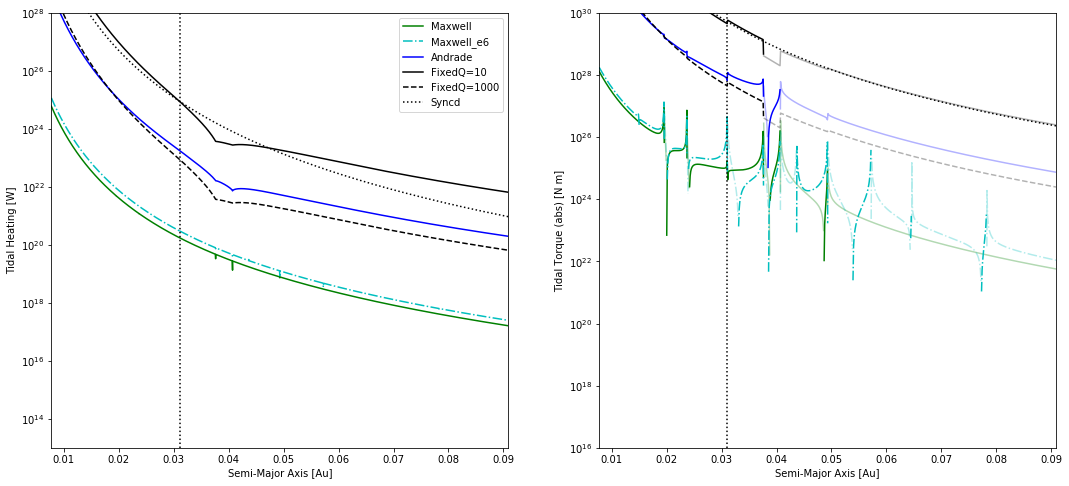

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# x-limits
xlim1 = m2Au(orbital_motion2semi_a(days2rads(.25), star_mass, planet_mass))
xlim2 = m2Au(orbital_motion2semi_a(days2rads(10.), star_mass, planet_mass))
xlim = (xlim1, xlim2)

for rheo_name, (comp_func, comp_input, style) in rheology_data.items():
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_byrheo[rheo_name]
    
    # Get consistent rheology style information
    # rheo_style = rheology_styles[rheo_name.lower()]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_au, tidal_heating, label=rheo_name, **style)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_au, tidal_torque, label=rheo_name, **style)
    axes[1].plot(semi_major_axis_au, tidal_torque_neg, label=rheo_name, alpha=0.3, **style)

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Tidal Heating [W]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Tidal Torque (abs) [N m]')
axes[1].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[0].set_ylim((1e13, 1e28))
axes[1].set_ylim((1e16, 1e30))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

In [9]:
# TODO: FITTING
# X = semi_major_axis_au
# Y0 = heating_real_q100[loc, :]
# Y1 = heating_real[loc, :]
# Y2 = heating_estimate[loc, :]
# Y3 = heating_maxwell[loc, :]
# Y4 = np.nan_to_num(heating_andrade[loc, :])
# Y4[Y4==0.] = 1e-10
# 
# Y1_fit = np.polyfit(np.log(X), np.log(Y1), 1)
# Y0_fit = np.polyfit(np.log(X), np.log(Y0), 1)
# Y2_fit = np.polyfit(np.log(X), np.log(Y2), 1)
# Y3_fit = np.polyfit(np.log(X), np.log(Y3), 1)
# Y4_fit = np.polyfit(np.log(X), np.log(Y4), 1)
# 
# print(f'Spin-Sync (Q=10) Fit: [m={Y2_fit[0]:0.5}, b={np.exp(Y2_fit[1]):0.2e}]')
# print(f'NSR Q=10 Fit: [m={Y1_fit[0]:0.5}, b={np.exp(Y1_fit[1]):0.2e}]')
# print(f'NSR Q=1000 Fit: [m={Y0_fit[0]:0.5}, b={np.exp(Y0_fit[1]):0.2e}]')
# print(f'Maxwell Fit: [m={Y3_fit[0]:0.5}, b={np.exp(Y3_fit[1]):0.2e}]')
# print(f'Andrade Fit: [m={Y4_fit[0]:0.5}, b={np.exp(Y4_fit[1]):0.5e}]')

### Plot Set 2 (semi-major axis ^7.5)

Lighter colors on the tidal torque plot indicate a negative torque.


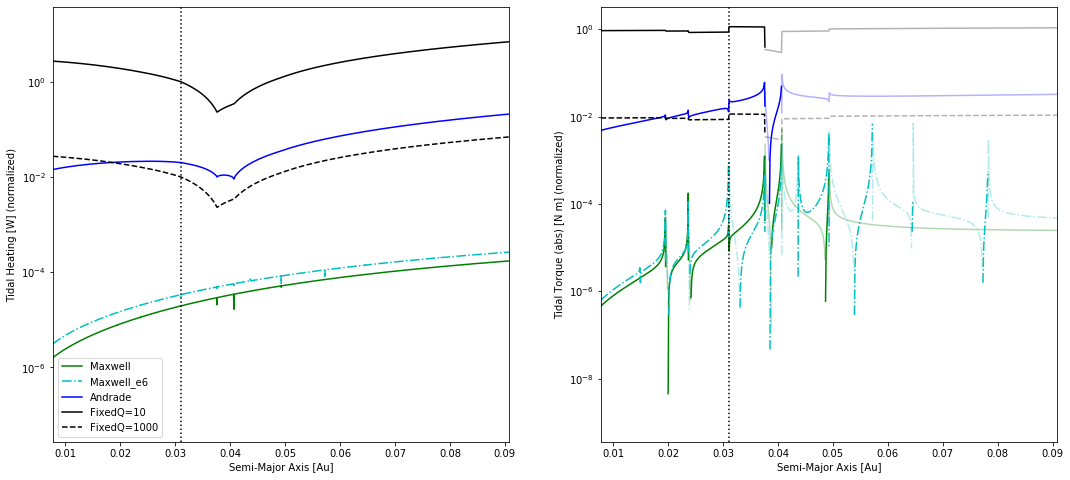

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# Pull out the sync results to act as a scalar
heating_sync = tidal_heating_byrheo['Syncd']
torque_sync = tidal_torque_real_byrheo['Syncd']

for rheo_name, (comp_func, comp_input, style) in rheology_data.items():
    
    if rheo_name == 'Syncd':
        continue
    
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_byrheo[rheo_name]
    
    # Get consistent rheology style information
    # rheo_style = rheology_styles[rheo_name.lower()]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_au, tidal_heating/heating_sync, label=rheo_name, **style)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_au, tidal_torque/torque_sync, label=rheo_name, **style)
    axes[1].plot(semi_major_axis_au, tidal_torque_neg/torque_sync, alpha=0.3, **style)

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Tidal Heating [W] (normalized)')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Tidal Torque (abs) [N m] (normalized)')
axes[1].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

## Orbital Evolution

In [11]:
from TidalPy.dynamics.single_dissipation import spin_rate_derivative, semi_major_axis_derivative, eccentricity_derivative
from TidalPy.utilities.conversions import sec2myr

In [12]:
spin_rate_timescale_byrheo = dict()
semi_major_axis_derivative_byrheo = dict()
eccentricity_timescale_byrheo = dict()

for rheo_name, (comp_func, comp_input, style) in rheology_data.items():
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_real_byrheo[rheo_name]
    
    # Calculate Derivatives
    da_dt = semi_major_axis_derivative(semi_major_axis, star_mass, planet_mass, spin_frequency, tidal_torque, tidal_heating)
    de_dt = eccentricity_derivative(semi_major_axis, eccentricity, star_mass, planet_mass, spin_frequency, tidal_torque, tidal_heating)
    dO_dt = spin_rate_derivative(tidal_torque, moi)
    
    # Calculate Timescales
    tau_e = sec2myr(-eccentricity / de_dt)
    tau_O = sec2myr(-abs(spin_frequency - orbital_frequency) / dO_dt)
    
    # Convert [m s-1] to [au myr-1]
    da_dt = m2Au(da_dt) * 3.154e13
    
    # Store
    spin_rate_timescale_byrheo[rheo_name] = tau_O
    semi_major_axis_derivative_byrheo[rheo_name] = da_dt
    eccentricity_timescale_byrheo[rheo_name] = tau_e 


Lighter colors on the tidal torque plot indicate a negative torque.


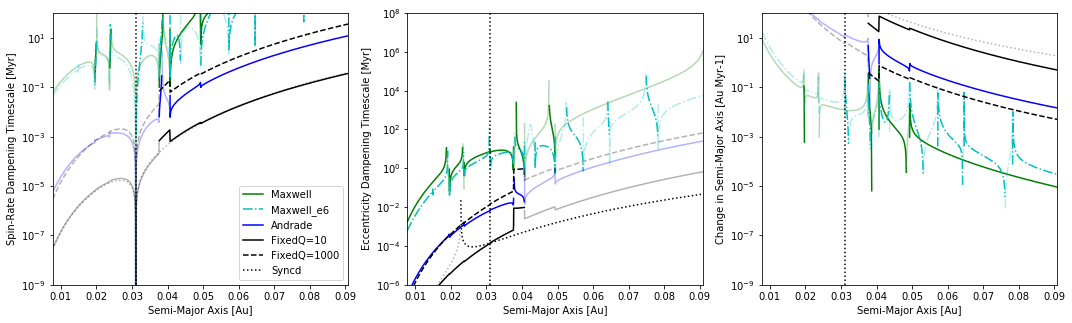

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for rheo_name, (comp_func, comp_input, style) in rheology_data.items():
    # Get Data
    tau_O = spin_rate_timescale_byrheo[rheo_name]
    da_dt = semi_major_axis_derivative_byrheo[rheo_name]
    tau_e = eccentricity_timescale_byrheo[rheo_name]
    
    # Flip negatives
    tau_O_neg = np.zeros_like(tau_O)
    tau_O_neg[tau_O < 0.] = -tau_O[tau_O < 0.]
    tau_O_neg[tau_O_neg <= 0.] = np.nan
    tau_O[tau_O <= 0.] = np.nan
    
    da_dt_neg = np.zeros_like(da_dt)
    da_dt_neg[da_dt < 0.] = -da_dt[da_dt < 0.]
    da_dt_neg[da_dt_neg <= 0.] = np.nan
    da_dt[da_dt <= 0.] = np.nan
    
    tau_e_neg = np.zeros_like(tau_e)
    tau_e_neg[tau_e < 0.] = -tau_e[tau_e < 0.]
    tau_e_neg[tau_e_neg <= 0.] = np.nan
    tau_e[tau_e <= 0.] = np.nan
    
    # Spin Timescales
    axes[0].plot(semi_major_axis_au, tau_O, label=rheo_name, **style)
    axes[0].plot(semi_major_axis_au, tau_O_neg, alpha=0.3, **style)
    
    # Eccentricity Timescales
    axes[1].plot(semi_major_axis_au, tau_e, label=rheo_name, **style)
    axes[1].plot(semi_major_axis_au, tau_e_neg, alpha=0.3, **style)
    
    # Semi-major Axis
    axes[2].plot(semi_major_axis_au, da_dt, label=rheo_name, **style)
    axes[2].plot(semi_major_axis_au, da_dt_neg, alpha=0.3, **style)

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[2].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Spin-Rate Dampening Timescale [Myr]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Eccentricity Dampening Timescale [Myr]')
axes[1].set_yscale('log')
axes[2].set_xlabel('Semi-Major Axis [Au]')
axes[2].set_ylabel('Change in Semi-Major Axis [Au Myr-1]')
axes[2].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[2].set_xlim(xlim)
axes[0].set_ylim((1e-9, 1e2))
axes[1].set_ylim((1e-6, 1e8))
axes[2].set_ylim((1e-9, 1e2))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()